In [1]:
import numpy as np
from common.functions import sigmoid


class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        # slice
        f = A[:, :H]
        g = A[:, H : 2 * H]
        i = A[:, 2 * H : 3 * H]
        o = A[:, 3 * H :]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next


In [2]:
# coding: utf-8
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import softmax, sigmoid


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.x = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        self.layers = []
        hs = np.empty((N, T, H), dtype="f")

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype="f")
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype="f")

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype="f")
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


In [4]:
import sys
from common.time_layers import *
import pickle

sys.path.append("..")


class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype("f")
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype("f")
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(D)).astype("f")
        lstm_b = np.zeros(4 * H).astype("f")
        affine_W = (rn(H, V) / np.sqrt(H)).astype("f")
        affine_b = np.zeros(V).astype("f")

        # レイヤーの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]

        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name="Rnnlm.pkl"):
        with open(file_name, "wb") as f:
            pickle.dump(self.params, f)

    def load_params(self, file_name="Rnnlm.pkl"):
        with open(file_name, "rb") as f:
            self.params = pickle.load(f)


Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.86
| epoch 1 |  iter 21 / 1327 | time 4[s] | perplexity 3216.92
| epoch 1 |  iter 41 / 1327 | time 8[s] | perplexity 1266.66
| epoch 1 |  iter 61 / 1327 | time 15[s] | perplexity 972.46
| epoch 1 |  iter 81 / 1327 | time 19[s] | perplexity 779.69
| epoch 1 |  iter 101 / 1327 | time 23[s] | perplexity 653.31
| epoch 1 |  iter 121 / 1327 | time 27[s] | perplexity 628.72
| epoch 1 |  iter 141 / 1327 | time 31[s] | perplexity 586.82
| epoch 1 |  iter 161 / 1327 | time 35[s] | perplexity 588.69
| epoch 1 |  iter 181 / 1327 | time 39[s] | perplexity 593.03
| epoch 1 |  iter 201 / 1327 | time 43[s] | perplexity 508.01
| epoch 1 |  iter 221 / 1327 | time 47[s] | perplexity 486.28
| epoch 1 |  iter 241 / 1327 | time 51[s] | perplexity 440.12
| epoch 1 |  iter 261 / 1327 | time 56[s] | perplexity 477.40
| epoch 1 |  iter 281 / 1327 | time 60[s] | perplexity 446.76
| epoch 1 |  iter 301 / 1327 | time 64[s] | perplexity 398.02
| epoch 1

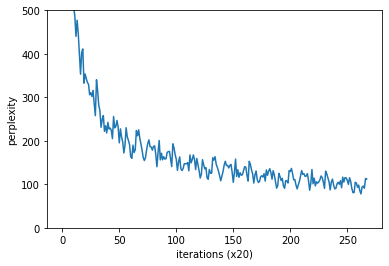

evaluating perplexity ...
234 / 235
test perplexity:  137.4955735400256


In [5]:
from pickletools import optimize
import sys
sys.path.append("..")
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm

# ハイパーパラメータの設定
batch_size=20
wordvec_size=100
hidden_size=100 # RNNの隠れ状態ベクトルの要素数
time_size=35#RNNを展開するサイズ
lr = 20.0
max_epoch=4
max_grad=0.25

# 学習データの読み込み
corpus,word_to_id, id_to_word=ptb.load_data("train")
corpus_test, _,_=ptb.load_data("test")
vocab_size=len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch,batch_size, time_size,max_grad,eval_interval=20)
trainer.plot(ylim=(0,500))

# テストデータで評価
model.reset_state()
ppl_test=eval_perplexity(model, corpus_test)
print("test perplexity: ",ppl_test)

# パラメータの保存
model.save_params()

In [6]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# ==============================================
config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)


Done
| epoch 1 |  iter 1 / 1327 | time 2[s] | perplexity 10000.06


KeyboardInterrupt: 